In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import os
import cv2
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from torchsummary import summary
from torchinfo import summary

In [ ]:
class CNNLSTM(nn.Module):
    def __init__(self, num_classes=3):
        super(CNNLSTM, self).__init__()
        
        self.cnn = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Flatten(),
        )
        
        self.cnn_output_size = self._get_cnn_output_size((1, 120, 120))
        
        self.lstm = nn.LSTM(self.cnn_output_size, 128, batch_first=True)
        self.dropout = nn.Dropout(0.5)
        self.fc = nn.Linear(128, num_classes)
        self.softmax = nn.Softmax(dim=1)

    def _get_cnn_output_size(self, input_shape):
        with torch.no_grad():
            x = torch.zeros(1, *input_shape)
            x = self.cnn(x)
            return x.shape[1]

    def forward(self, x):
        
        batch_size, seq_len, C, H, W = x.shape
        c_out = x.view(batch_size * seq_len, C, H, W)
        c_out = self.cnn(c_out)
        c_out = c_out.view(batch_size, seq_len, -1)
        lstm_out, (hn, cn) = self.lstm(c_out)
        out = lstm_out[:, -1, :]
        out = self.dropout(out)
        out = self.fc(out)
        out = self.softmax(out)
        return out


class VideoDataset(Dataset):
    def __init__(self, sequences, labels, sequence_length=80, img_size=120):
        self.sequences = sequences
        self.labels = labels
        self.sequence_length = sequence_length
        self.img_size = img_size

    def __len__(self):
        return len(self.sequences)

    def __getitem__(self, idx):
        sequence = self.sequences[idx]
        label = self.labels[idx]
        sequence = torch.tensor(sequence, dtype=torch.float32).permute(0, 3, 1, 2)  
        return sequence, torch.tensor(label, dtype=torch.long)

# Data loading
DATA_PATH = 'C://MajorProject//frames'
SEQUENCE_LENGTH = 80
IMG_SIZE = 120

# Define labels
actions = np.array(['Anuman', 'Badhi'])
label_map = {label: i for i, label in enumerate(actions)}

sequences = []
labels = []

In [ ]:
#frame laude
sequences = []
labels = []
for action in actions:
    for sequence in os.listdir(os.path.join(DATA_PATH, action)):
        window = []
        for frame_num in range(SEQUENCE_LENGTH):
            path = os.path.join(DATA_PATH, action, sequence, f'{frame_num}.jpg')
            if os.path.exists(path):
                frame = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
                frame = cv2.resize(frame, (IMG_SIZE, IMG_SIZE))
                window.append(frame)
        if len(window) == SEQUENCE_LENGTH:
            sequences.append(np.array(window)[..., np.newaxis])  # Add channel dimension
            labels.append(label_map[action])

X = np.array(sequences)  # Shape: (N, 80, 120, 120, 1)
y = np.array(labels)     # Shape: (N,)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [ ]:
# DatasetLaude
train_dataset = VideoDataset(X_train, y_train, SEQUENCE_LENGTH, IMG_SIZE)
test_dataset = VideoDataset(X_test, y_test, SEQUENCE_LENGTH, IMG_SIZE)
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False)


device = torch.device('cuda')
model = CNNLSTM(num_classes=2).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0000001)

# Print model summary
summary(model, input_size=(1, 80, 1, 120, 120), device=device)

print(f'Training data shape: {X_train.shape}')
print(f'Test data shape: {X_test.shape}')

Training data shape: (42, 80, 120, 120, 1)
Test data shape: (18, 80, 120, 120, 1)


In [ ]:
# Check for GPU availability
print(f'PyTorch version: {torch.__version__}')
print(f'CUDA available: {torch.cuda.is_available()}')
print(f'GPU devices: {torch.cuda.device_count()}')
if torch.cuda.is_available():
    print(f'Current GPU: {torch.cuda.get_device_name(0)}')

In [ ]:
num_epochs = 20
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0
    train_correct = 0
    train_total = 0

    for sequences, labels in train_loader:
        sequences, labels = sequences.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(sequences)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.item() * sequences.size(0)
        _, predicted = torch.max(outputs.data, 1)
        train_total += labels.size(0)
        train_correct += (predicted == labels).sum().item()

    train_loss = train_loss / len(train_loader.dataset)
    train_accuracy = train_correct / train_total
    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)

    # Val
    model.eval()
    val_loss = 0.0
    val_correct = 0
    val_total = 0

    with torch.no_grad():
        for sequences, labels in test_loader:
            sequences, labels = sequences.to(device), labels.to(device)
            outputs = model(sequences)
            loss = criterion(outputs, labels)

            val_loss += loss.item() * sequences.size(0)
            _, predicted = torch.max(outputs.data, 1)
            val_total += labels.size(0)
            val_correct += (predicted == labels).sum().item()

    val_loss = val_loss / len(test_loader.dataset)
    val_accuracy = val_correct / val_total
    val_losses.append(val_loss)
    val_accuracies.append(val_accuracy)

    print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Train Acc: {train_accuracy:.4f}, Val Loss: {val_loss:.4f}, Val Acc: {val_accuracy:.4f}')

Epoch 1/20, Train Loss: 0.6944, Train Acc: 0.5476, Val Loss: 0.6977, Val Acc: 0.4444
Epoch 2/20, Train Loss: 0.6926, Train Acc: 0.5952, Val Loss: 0.6975, Val Acc: 0.4444
Epoch 3/20, Train Loss: 0.7173, Train Acc: 0.3810, Val Loss: 0.6974, Val Acc: 0.4444
Epoch 4/20, Train Loss: 0.7140, Train Acc: 0.4286, Val Loss: 0.6973, Val Acc: 0.4444
Epoch 5/20, Train Loss: 0.6814, Train Acc: 0.5952, Val Loss: 0.6972, Val Acc: 0.4444
Epoch 6/20, Train Loss: 0.6972, Train Acc: 0.5000, Val Loss: 0.6971, Val Acc: 0.4444
Epoch 7/20, Train Loss: 0.6790, Train Acc: 0.5714, Val Loss: 0.6971, Val Acc: 0.5000
Epoch 8/20, Train Loss: 0.7010, Train Acc: 0.5000, Val Loss: 0.6971, Val Acc: 0.5000
Epoch 9/20, Train Loss: 0.6957, Train Acc: 0.5714, Val Loss: 0.6969, Val Acc: 0.5000
Epoch 10/20, Train Loss: 0.6836, Train Acc: 0.6190, Val Loss: 0.6968, Val Acc: 0.5000
Epoch 11/20, Train Loss: 0.7102, Train Acc: 0.4048, Val Loss: 0.6966, Val Acc: 0.5000
Epoch 12/20, Train Loss: 0.7052, Train Acc: 0.5000, Val Loss: 0

<Figure size 1200x500 with 0 Axes>

<Figure size 1200x500 with 0 Axes>

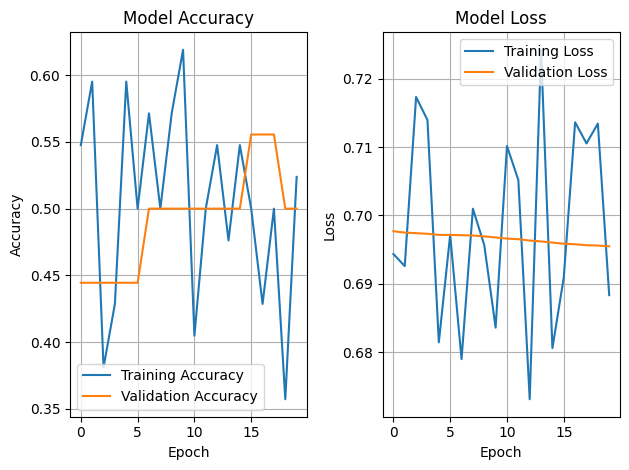

In [ ]:
plt.figure(figsize=(12, 5))
# Accuracy plot
plt.subplot(1, 2, 1)
plt.plot(train_accuracies, label='Training Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

# Loss plot
plt.subplot(1, 2, 2)
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

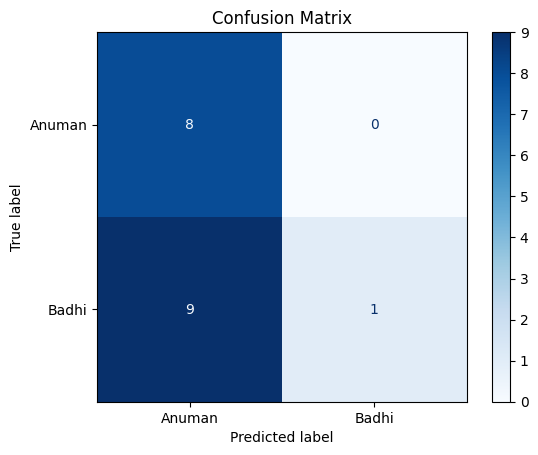

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import numpy as np

# Put model in evaluation mode
model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for sequences, labels in test_loader:
        sequences, labels = sequences.to(device), labels.to(device)
        outputs = model(sequences)
        _, predicted = torch.max(outputs.data, 1)
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Compute confusion matrix
cm = confusion_matrix(all_labels, all_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=actions)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()

In [ ]:

torch.save(model.state_dict(), 'model_weights.pth')

In [ ]:
# # Check for GPU availability
# print(f'PyTorch version: {torch.__version__}')
# print(f'CUDA available: {torch.cuda.is_available()}')
# print(f'GPU devices: {torch.cuda.device_count()}')
# if torch.cuda.is_available():
#     print(f'Current GPU: {torch.cuda.get_device_name(0)}')

PyTorch version: 2.7.1+cu118
CUDA available: True
GPU devices: 1
Current GPU: NVIDIA GeForce RTX 4060 Laptop GPU
